# Importing Libraries And Datasets:

In [126]:
import pandas as pd 
import numpy as np

In [127]:
match = pd.read_csv(r"C:\Users\DELL\Desktop\Project\ipl prediction\matches.csv")
delivery=  pd.read_csv(r"C:\Users\DELL\Desktop\Project\ipl prediction\deliveries.csv")

In [128]:
match.head(2)

,id,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,IPL-2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,IPL-2017,Pune,06-04-2017,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN


In [129]:
delivery.head(2)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN


# Data Preprocessing :

* Creating total score column in First inning

In [130]:
total_score_df=delivery.groupby(['match_id','inning']).sum()['total_runs'].reset_index()

In [131]:
total_score_df=total_score_df[total_score_df['inning']==1]

In [132]:
total_score_df

,match_id,inning,total_runs
0,1,1,207
2,2,1,184
4,3,1,183
6,4,1,163
8,5,1,157
...,...,...,...
1518,11347,1,143
1520,11412,1,136
1522,11413,1,171
1524,11414,1,155


In [133]:
match_df=match.merge(total_score_df[['match_id','total_runs']],left_on='id',right_on='match_id')

In [134]:
match_df['team1'].unique()

array(['Sunrisers Hyderabad', 'Mumbai Indians', 'Gujarat Lions',
       'Rising Pune Supergiant', 'Royal Challengers Bangalore',
       'Kolkata Knight Riders', 'Delhi Daredevils', 'Kings XI Punjab',
       'Chennai Super Kings', 'Rajasthan Royals', 'Deccan Chargers',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Rising Pune Supergiants',
       'Delhi Capitals'], dtype=object)

In [135]:
teams=['Sunrisers Hyderabad', 'Mumbai Indians', 'Royal Challengers Bangalore',
       'Kolkata Knight Riders','Kings XI Punjab',
       'Chennai Super Kings', 'Rajasthan Royals','Delhi Capitals']

In [136]:
match_df['team1']=match_df['team1'].str.replace('Delhi Daredevils','Delhi Capitals')
match_df['team2']=match_df['team2'].str.replace('Delhi Daredevils','Delhi Capitals')

match_df['team1']=match_df['team1'].str.replace('Deccan Chargers','Sunrisers Hyderabad')
match_df['team2']=match_df['team2'].str.replace('Deccan Chargers','Sunrisers Hyderabad')


In [137]:
match_df=match_df[match_df['team1'].isin(teams)]
match_df=match_df[match_df['team2'].isin(teams)]

In [138]:
match_df.shape

(641, 20)

* Checking Matches that cancelled due to rain -:

In [139]:
match_df=match_df[match['dl_applied']==0]

C:\Users\DELL\AppData\Local\Temp\ipykernel_1968\4159031910.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  match_df=match_df[match['dl_applied']==0]


* Extracting Required Columns from match data in delivery data -:

In [140]:
match_df=match_df[['match_id','city','winner','total_runs']]

In [141]:
delivery_df=match_df.merge(delivery,on='match_id')

In [142]:
delivery_df.head(2)

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batsman,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder
0,1,Hyderabad,Sunrisers Hyderabad,207,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,Hyderabad,Sunrisers Hyderabad,207,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,...,0,0,0,0,0,0,0,NaN,NaN,NaN


In [143]:
delivery_df=delivery_df[delivery_df['inning']==2]

* Current Score -:

In [144]:
delivery_df['current_score']=delivery_df.groupby('match_id').cumsum()['total_runs_y']

* Runs Left -:

In [145]:
delivery_df['runs_left']=delivery_df['total_runs_x']-delivery_df['current_score']

* Balls Left -:

In [146]:
delivery_df['balls_left']= 126 - (delivery_df['over']*6+delivery_df['ball'])

* Wickets -:

In [147]:
delivery_df['player_dismissed']=delivery_df['player_dismissed'].fillna('0')
delivery_df['player_dismissed']=delivery_df['player_dismissed'].apply(lambda x:x if x=='0'else "1")
delivery_df['player_dismissed']=delivery_df['player_dismissed'].astype('int')
wickets= delivery_df.groupby('match_id').cumsum()['player_dismissed'].values
delivery_df['wickets']=10- wickets
delivery_df.head()

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batsman,...,batsman_runs,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder,current_score,runs_left,balls_left,wickets
125,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,1,0,1,0,NaN,NaN,1,206,119,10
126,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,0,0,NaN,NaN,1,206,118,10
127,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,0,0,NaN,NaN,1,206,117,10
128,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,2,0,2,0,NaN,NaN,3,204,116,10
129,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,4,0,4,0,NaN,NaN,7,200,115,10


* Current Runrate -: crr=runs/ovres

In [148]:
delivery_df['crr']=delivery_df['current_score']*6/(120 - delivery_df['balls_left'])

* Required Run Rate -:

In [149]:
delivery_df['rrr']=(delivery_df['runs_left']*6)/delivery_df['balls_left']

* Result -:

In [150]:
def result(row):
    return 1 if row['batting_team']==row['winner'] else 0

In [151]:
delivery_df['result']=delivery_df.apply(result,axis=1)

In [152]:
final_df=delivery_df[['batting_team','bowling_team','city','runs_left','balls_left','wickets','total_runs_x','crr','rrr','result']]

In [153]:
final_df=final_df.sample(final_df.shape[0])

In [154]:
final_df.sample()

,batting_team,bowling_team,city,runs_left,balls_left,wickets,total_runs_x,crr,rrr,result
2597,Kings XI Punjab,Sunrisers Hyderabad,Hyderabad,102,70,7,159,6.84,8.742857,0


In [155]:
final_df.isnull().sum()

batting_team      0
bowling_team      0
city            832
runs_left         0
balls_left        0
wickets           0
total_runs_x      0
crr               0
rrr               7
result            0
dtype: int64

In [156]:
final_df.dropna(inplace=True)

In [157]:
final_df=final_df[final_df['balls_left']!=0]

# Model Building :

In [158]:
x=final_df.iloc[:,:-1]


In [159]:
y=final_df.iloc[:,-1]

In [160]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=1)

In [161]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
trf = ColumnTransformer([('trf',OneHotEncoder(sparse=False,drop='first'),['batting_team','bowling_team','city'])
]
,remainder='passthrough')

In [162]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [163]:
pipe=Pipeline(steps=[('step1',trf),('step2',LogisticRegression(solver='liblinear'))])

In [164]:
pipe.fit(x_train,y_train)

Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('trf',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('step2', LogisticRegression(solver='liblinear'))])

In [165]:
y_pred= pipe.predict(x_test)

In [166]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.8016679515032588

In [167]:
def match_progression(x_df,match_id,pipe):
    match = x_df[x_df['match_id'] == match_id]
    match = match[(match['ball'] == 6)]
    temp_df = match[['batting_team','bowling_team','city','runs_left','balls_left','wickets','total_runs_x','crr','rrr']].dropna()
    temp_df = temp_df[temp_df['balls_left'] != 0]
    result = pipe.predict_proba(temp_df)
    temp_df['lose'] = np.round(result.T[0]*100,1)
    temp_df['win'] = np.round(result.T[1]*100,1)
    temp_df['end_of_over'] = range(1,temp_df.shape[0]+1)
    
    target = temp_df['total_runs_x'].values[0]
    runs = list(temp_df['runs_left'].values)
    new_runs = runs[:]
    runs.insert(0,target)
    temp_df['runs_after_over'] = np.array(runs)[:-1] - np.array(new_runs)
    wickets = list(temp_df['wickets'].values)
    new_wickets = wickets[:]
    new_wickets.insert(0,10)
    wickets.append(0)
    w = np.array(wickets)
    nw = np.array(new_wickets)
    temp_df['wickets_in_over'] = (nw - w)[0:temp_df.shape[0]]
    
    print("Target-",target)
    temp_df = temp_df[['end_of_over','runs_after_over','wickets_in_over','lose','win']]
    return temp_df,target
    

In [168]:
temp_df,target = match_progression(delivery_df,74,pipe)
temp_df

Target- 178


,end_of_over,runs_after_over,wickets_in_over,lose,win
10459,1,4,0,56.5,43.5
10467,2,8,0,50.8,49.2
10473,3,1,0,57.9,42.1
10479,4,7,1,69.4,30.6
10485,5,12,0,59.2,40.8
10491,6,13,0,46.7,53.3
10497,7,9,0,40.8,59.2
10505,8,15,0,27.1,72.9
10511,9,7,0,25.0,75.0
10518,10,17,0,13.7,86.3


Text(0.5, 1.0, 'Target-178')

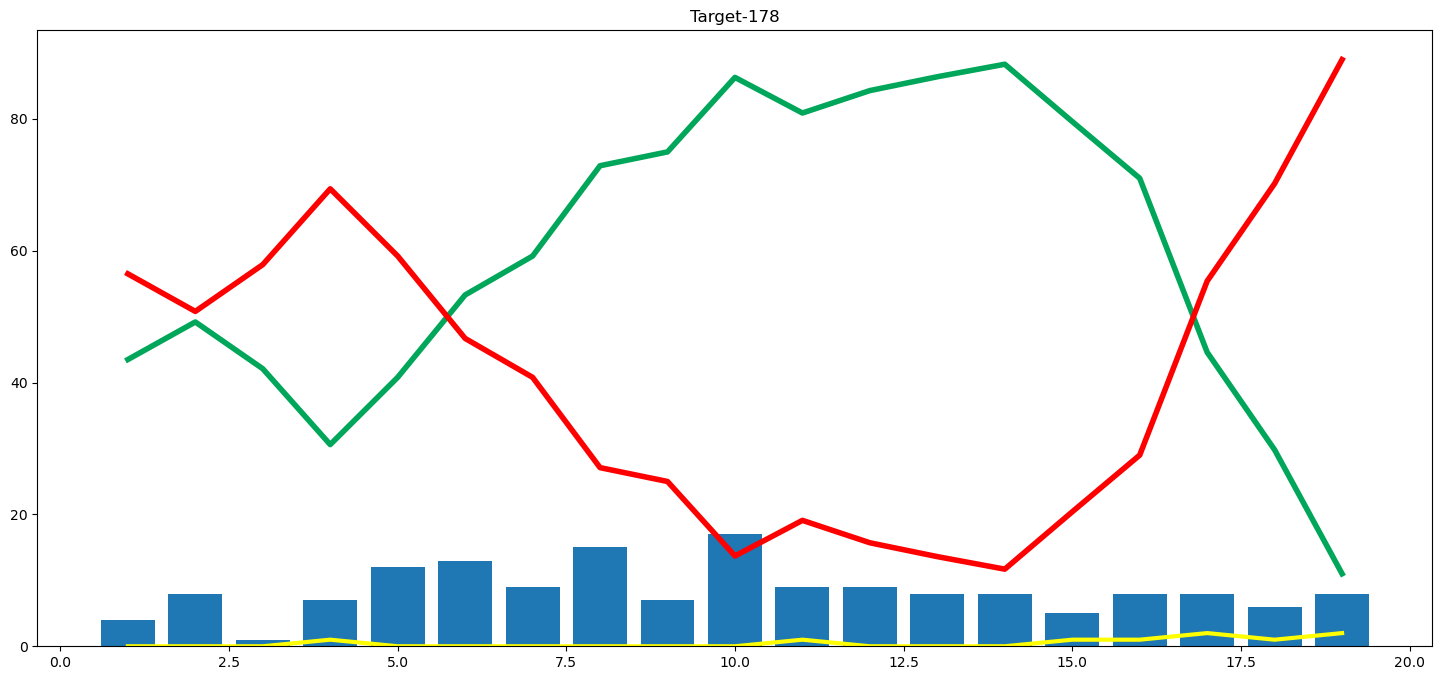

In [169]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,8))
plt.plot(temp_df['end_of_over'],temp_df['wickets_in_over'],color='yellow',linewidth=3)
plt.plot(temp_df['end_of_over'],temp_df['win'],color='#00a65a',linewidth=4)
plt.plot(temp_df['end_of_over'],temp_df['lose'],color='red',linewidth=4)
plt.bar(temp_df['end_of_over'],temp_df['runs_after_over'])
plt.title('Target-' + str(target))

* columns we need for web deployment :

In [170]:
teams

['Sunrisers Hyderabad',
 'Mumbai Indians',
 'Royal Challengers Bangalore',
 'Kolkata Knight Riders',
 'Kings XI Punjab',
 'Chennai Super Kings',
 'Rajasthan Royals',
 'Delhi Capitals']

In [171]:
delivery_df['city'].unique()

array(['Hyderabad', 'Bangalore', 'Mumbai', 'Indore', 'Kolkata', 'Delhi',
       'Chandigarh', 'Jaipur', 'Chennai', 'Cape Town', 'Port Elizabeth',
       'Durban', 'Centurion', 'East London', 'Johannesburg', 'Kimberley',
       'Bloemfontein', 'Ahmedabad', 'Cuttack', 'Nagpur', 'Dharamsala',
       'Visakhapatnam', 'Pune', 'Raipur', 'Ranchi', 'Abu Dhabi',
       'Sharjah', nan, 'Mohali', 'Bengaluru'], dtype=object)

In [172]:
# Drop duplicates from the match dataframe based on the 'id' column
match = match.drop_duplicates(subset=['id'], keep='first')

# Drop duplicates from the delivery dataframe based on the 'match_id' column
delivery = delivery.drop_duplicates(subset=['match_id'], keep='first')


In [173]:
# Drop duplicates from the match dataframe based on the 'id' column
match = match.drop_duplicates(subset=['id'], keep='first')

# Drop duplicates from the delivery dataframe based on the 'match_id' column
delivery = delivery.drop_duplicates(subset=['match_id'], keep='first')

# Merge the cleaned match and delivery dataframes on the 'id' column
merged_data = pd.merge(match, delivery, left_on='id', right_on='match_id', how='inner')

# Print the merged dataframe
print(merged_data)


        id    Season           city        date                        team1  \
0        1  IPL-2017      Hyderabad  05-04-2017          Sunrisers Hyderabad   
1        2  IPL-2017           Pune  06-04-2017               Mumbai Indians   
2        3  IPL-2017         Rajkot  07-04-2017                Gujarat Lions   
3        4  IPL-2017         Indore  08-04-2017       Rising Pune Supergiant   
4        5  IPL-2017      Bangalore  08-04-2017  Royal Challengers Bangalore   
..     ...       ...            ...         ...                          ...   
751  11347  IPL-2019         Mumbai  05-05-2019        Kolkata Knight Riders   
752  11412  IPL-2019        Chennai  07-05-2019          Chennai Super Kings   
753  11413  IPL-2019  Visakhapatnam  08-05-2019          Sunrisers Hyderabad   
754  11414  IPL-2019  Visakhapatnam  10-05-2019               Delhi Capitals   
755  11415  IPL-2019      Hyderabad  12-05-2019               Mumbai Indians   

                           team2       

In [186]:
merged_data['team1']=merged_data['team1'].str.replace('Delhi Daredevils','Delhi Capitals')
merged_data['team2']=merged_data['team2'].str.replace('Delhi Daredevils','Delhi Capitals')

merged_data['team1']=merged_data['team1'].str.replace('Deccan Chargers','Sunrisers Hyderabad')
merged_data['team2']=merged_data['team2'].str.replace('Deccan Chargers','Sunrisers Hyderabad')


In [187]:
merged_data=merged_data[merged_data['team1'].isin(teams)]
merged_data=merged_data[merged_data['team2'].isin(teams)]

* overall Team Information :

In [188]:
def get_teams_info(data):
    
    # Get unique team names
    teams = list(set(data['team1']).union(set(data['team2'])))
    
    # Initialize empty lists for each column in the dataframe
    matches_played = []
    total_wins = []
    total_losses = []
    win_percentage = []
    
    # Loop through each team
    for team in teams:
        # Count the number of matches played by the team
        matches = len(data[(data['team1'] == team) | (data['team2'] == team)])
        
        # Count the number of wins and losses by the team
        wins = len(data[(data['winner'] == team)])
        losses = matches - wins
        
        # Calculate the win percentage
        win_percent = (wins / matches) * 100 if matches > 0 else 0
        
        # Append the values to the respective lists
        matches_played.append(matches)
        total_wins.append(wins)
        total_losses.append(losses)
        win_percentage.append(win_percent)
    
    # Create the dataframe
    teams_info = pd.DataFrame({
        'Team': teams,
        'Matches Played': matches_played,
        'Total Wins': total_wins,
        'Total Losses': total_losses,
        'Win Percentage': win_percentage
    })
    
    return teams_info


In [199]:

teams_info = get_teams_info(merged_data)
print(teams_info)


                          Team  Matches Played  Total Wins  Total Losses  \
0               Mumbai Indians             170         100            70   
1          Sunrisers Hyderabad             167          50           117   
2               Delhi Capitals             161          10           151   
3        Kolkata Knight Riders             163          84            79   
4             Rajasthan Royals             140          70            70   
5              Kings XI Punjab             161          74            87   
6          Chennai Super Kings             156          95            61   
7  Royal Challengers Bangalore             164          72            92   

   Win Percentage  
0       58.823529  
1       29.940120  
2        6.211180  
3       51.533742  
4       50.000000  
5       45.962733  
6       60.897436  
7       43.902439  


* team info -:

In [190]:
def get_team_info(team_name):
    # Filter the match dataframe to get all matches played by the selected team
    team_matches = match[(match['team1'] == team_name) | (match['team2'] == team_name)]
    
    # Get the total number of matches played by the team
    total_matches = len(team_matches)
    
    # Get the total number of matches won by the team
    total_wins = len(team_matches[team_matches['winner'] == team_name])
    
    # Get the total number of matches lost by the team
    total_losses = len(team_matches[team_matches['winner'] != team_name])
    
    # Get the total number of matches tied by the team
    total_ties = len(team_matches[team_matches['result'] == 'tie'])
    
    # Print the team information
    print('Team Name:', team_name)
    print('Total Matches Played:', total_matches)
    print('Total Matches Won:', total_wins)
    print('Total Matches Lost:', total_losses)
    print('Total Matches Tied:', total_ties)


In [191]:
get_team_info('Kolkata Knight Riders')

Team Name: Kolkata Knight Riders
Total Matches Played: 178
Total Matches Won: 92
Total Matches Lost: 86
Total Matches Tied: 3


* overall players information :

In [192]:
def get_players_info(data):
    
    # Create a list of all players in the dataset
    all_players = list(set(data['player_of_match']))
    
    # Initialize empty lists for each column in the dataframe
    matches_played = []
    total_runs = []
    total_wickets = []
    total_catches = []
    
    # Loop through each player
    for player in all_players:
        # Count the number of matches played by the player
        matches = len(data[data['player_of_match'] == player])
        
        # Calculate the total runs, wickets, and catches taken by the player
        runs = data[data['player_of_match'] == player]['batsman_runs'].sum()
        wickets = data[data['player_of_match'] == player]['player_dismissed'].count()
        catches = data[data['player_of_match'] == player]['dismissal_kind'].str.contains('catch').sum()
        
        # Append the values to the respective lists
        matches_played.append(matches)
        total_runs.append(runs)
        total_wickets.append(wickets)
        total_catches.append(catches)
    
    # Create the dataframe
    players_info = pd.DataFrame({
        'Player': all_players,
        'Matches Played': matches_played,
        'Total Runs': total_runs,
        'Total Wickets': total_wickets,
        'Total Catches': total_catches
    })
    
    return players_info


In [193]:
players_info = get_players_info(merged_data)
print(players_info)


               Player  Matches Played  Total Runs  Total Wickets  \
0                 NaN               0           0              0   
1           SV Samson               4           5              0   
2            S Nadeem               1           0              0   
3            VR Aaron               2           0              0   
4         BCJ Cutting               1           1              0   
..                ...             ...         ...            ...   
201         MK Tiwary               3           1              0   
202  DPMD Jayawardene               4           2              0   
203          L Balaji               3           0              0   
204          H Gurney               1           0              0   
205          AR Patel               3           4              0   

     Total Catches  
0                0  
1                0  
2                0  
3                0  
4                0  
..             ...  
201              0  
202            

* Selected_player Information

In [232]:

merged_data['batsman'].unique()

array(['DA Warner', 'CH Gayle', 'G Gambhir', 'SR Watson', 'S Dhawan',
       'HM Amla', 'SP Narine', 'SV Samson', 'PA Patel', 'V Kohli',
       'LMP Simmons', 'MJ Guptill', 'SS Tiwary', 'CA Lynn', 'SC Ganguly',
       'T Kohli', 'L Ronchi', 'AC Gilchrist', 'K Goel', 'S Chanderpaul',
       'BB McCullum', 'GC Smith', 'SE Marsh', 'YV Takawale', 'W Jaffer',
       'A Chopra', 'MV Boucher', 'S Vidyut', 'Salman Butt', 'J Arunkumar',
       'ST Jayasuriya', 'JH Kallis', 'B Chipli', 'JD Ryder', 'RS Bopara',
       'HH Gibbs', 'M Vijay', 'NV Ojha', 'MN van Wyk', 'S Badrinath',
       'TL Suman', 'S Sohal', 'RJ Quiney', 'GJ Bailey', 'MK Tiwary',
       'SA Asnodkar', 'MJ Lumb', 'MD Mishra', 'MK Pandey', 'MS Bisla',
       'C Madan', 'DPMD Jayawardene', 'R McLaren', 'AP Tare',
       'S Anirudha', 'MA Agarwal', 'AG Paunikar', 'MEK Hussey',
       'R Sathish', 'DJ Jacobs', 'EJG Morgan', 'AC Blizzard',
       'PC Valthaty', 'F du Plessis', 'R Dravid', 'AB McDonald',
       'RE Levi', 'KC Sangakkar

In [198]:
import pickle
pickle.dump(pipe,open('pipe.pkl','wb'))

In [242]:
merged_data.columns

Index(['id', 'Season', 'city', 'date', 'team1', 'team2', 'toss_winner',
       'toss_decision', 'result', 'dl_applied', 'winner', 'win_by_runs',
       'win_by_wickets', 'player_of_match', 'venue', 'umpire1', 'umpire2',
       'umpire3', 'match_id', 'inning', 'batting_team', 'bowling_team', 'over',
       'ball', 'batsman', 'non_striker', 'bowler', 'is_super_over',
       'wide_runs', 'bye_runs', 'legbye_runs', 'noball_runs', 'penalty_runs',
       'batsman_runs', 'extra_runs', 'total_runs', 'player_dismissed',
       'dismissal_kind', 'fielder'],
      dtype='object')

In [243]:
import pandas as pd

# Group the data by player and aggregate the runs, wickets and matches played
player_data = merged_data.groupby('batsman').agg({
    'batsman_runs': 'sum',
    'player_dismissed': 'count',
    'match_id': 'nunique'
}).reset_index()

# Rename the columns to be more descriptive
player_data.columns = ['player_name', 'total_runs', 'wickets_taken', 'matches_played']

# Sort the data by total runs scored in descending order
player_data = player_data.sort_values('total_runs', ascending=False)

# Reset the index
player_data = player_data.reset_index(drop=True)

# Print the top 10 players by runs scored
print(player_data.head(10))


    player_name  total_runs  wickets_taken  matches_played
0     DA Warner          33              0              40
1      S Dhawan          22              1              20
2      DR Smith          21              1              25
3    MEK Hussey          20              0              15
4     SR Watson          20              0              19
5      V Sehwag          18              0               8
6     G Gambhir          17              1              19
7       M Vijay          17              0              25
8  AC Gilchrist          14              0              28
9      CH Gayle          13              1              25


In [244]:
merged_data['batsman_runs_cumulative'] = merged_data.groupby(['match_id', 'batsman'])['batsman_runs'].cumsum()


In [245]:
merged_data

,id,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,...,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder,batsman_runs_cumulative
0,1,IPL-2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,...,0,0,0,0,0,0,NaN,NaN,NaN,0
4,5,IPL-2017,Bangalore,08-04-2017,Royal Challengers Bangalore,Delhi Capitals,Royal Challengers Bangalore,bat,normal,0,...,0,0,0,1,0,1,NaN,NaN,NaN,1
6,7,IPL-2017,Mumbai,09-04-2017,Kolkata Knight Riders,Mumbai Indians,Mumbai Indians,field,normal,0,...,0,0,0,1,0,1,NaN,NaN,NaN,1
7,8,IPL-2017,Indore,10-04-2017,Royal Challengers Bangalore,Kings XI Punjab,Royal Challengers Bangalore,bat,normal,0,...,0,0,0,1,0,1,NaN,NaN,NaN,1
9,10,IPL-2017,Mumbai,12-04-2017,Sunrisers Hyderabad,Mumbai Indians,Mumbai Indians,field,normal,0,...,0,0,0,0,0,0,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,11347,IPL-2019,Mumbai,05-05-2019,Kolkata Knight Riders,Mumbai Indians,Mumbai Indians,field,normal,0,...,0,0,0,1,0,1,NaN,NaN,NaN,1
752,11412,IPL-2019,Chennai,07-05-2019,Chennai Super Kings,Mumbai Indians,Chennai Super Kings,bat,normal,0,...,0,0,0,0,0,0,NaN,NaN,NaN,0
753,11413,IPL-2019,Visakhapatnam,08-05-2019,Sunrisers Hyderabad,Delhi Capitals,Delhi Capitals,field,normal,0,...,0,0,0,0,0,0,NaN,NaN,NaN,0
754,11414,IPL-2019,Visakhapatnam,10-05-2019,Delhi Capitals,Chennai Super Kings,Chennai Super Kings,field,normal,0,...,0,0,0,1,1,2,NaN,NaN,NaN,1


In [253]:
import pandas as pd

def count_runs_by_player(data, player_name):
    # Filter the data to get rows where the player was either the batsman or the non-striker
    player_data = data[(data['batsman'] == player_name) | (data['non_striker'] == player_name)]

    # Group the data by match_id, inning, and batting_team, and sum up the runs scored by the player in each match
    player_runs = player_data.groupby(['match_id', 'inning', 'batting_team'])[["batsman_runs"]].sum()

    # Reset the index to get match_id, inning, batting_team, and runs as columns
    player_runs = player_runs.reset_index()

    # Rename the columns to be more descriptive
    player_runs.columns = ["match_id", "inning", "batting_team", "runs"]

    return player_runs


In [254]:
# Assuming merged_data is your merged dataset
player_runs = count_runs_by_player(merged_data, "MEK Hussey")
player_runs

,match_id,inning,batting_team,runs
0,248,1,Chennai Super Kings,1
1,272,1,Chennai Super Kings,0
2,281,1,Chennai Super Kings,0
3,285,1,Chennai Super Kings,4
4,289,1,Chennai Super Kings,1
5,302,1,Chennai Super Kings,1
6,307,1,Chennai Super Kings,1
7,347,1,Chennai Super Kings,2
8,371,1,Chennai Super Kings,0
9,379,1,Chennai Super Kings,0


In [256]:
p=merged_data[(merged_data['batsman'] == "MEK Hussey") | (merged_data['non_striker'] == "MEK Hussey")]

In [258]:
p.groupby(['match_id', 'inning', 'batting_team'])[["batsman_runs"]].sum()

,,,batsman_runs
match_id,inning,batting_team,
248,1,Chennai Super Kings,1
272,1,Chennai Super Kings,0
281,1,Chennai Super Kings,0
285,1,Chennai Super Kings,4
289,1,Chennai Super Kings,1
302,1,Chennai Super Kings,1
307,1,Chennai Super Kings,1
347,1,Chennai Super Kings,2
371,1,Chennai Super Kings,0


In [259]:
p = merged_data[(merged_data['batsman'] == "MEK Hussey") | (merged_data['non_striker'] == "MEK Hussey")]
runs_scored = p.groupby('match_id')['batsman_runs'].sum().sum()
matches_played = p['match_id'].nunique()


In [ ]:
mathc